<table>
<tr>
    <td width=25%>
        <img src=" 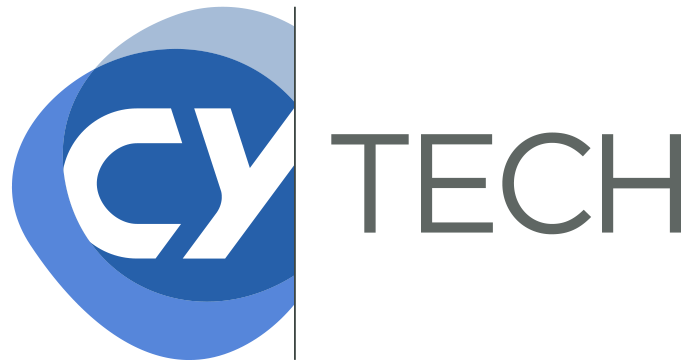" />
    </td>
    <td>
        <center>
            <h1>Deep Learning et Applications</h1>
        </center>
    </td>
    <td width=20%>
        Crée par Paul Gay <br/>
        Modifié par Yannick Le Nir
    </td>
</tr>
</table>

<br/>
<div id="top"></div>
<center>
    <a style="font-size: 20pt; font-weight: bold">Lab. 1 - Transformeurs. Introduction</a>
</center>
<br/>

---

Ce lab vous propose de manipuler les embedding contextuels. 

Nous allons: 

- Générer du texte à partir des transformeurs
- Obtenir des embedding et nous apercevoir qu'ils sont différents suivant leur contexte.

Nous utiliserons la librairie de la compagnie [Hugging face](https://huggingface.co/) qui donne accès à des modèles pré-entrainées
```
pip install transformers
```
Pour changer de Keras, nous allons également utiliser Pytorch :
```
pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
```

### Génération de texte 

Nous allons utiliser le model Camembert appris sur du français. Des modèles en anglais sont aussi disponibles

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

In [ ]:
model_name = "camembert-base"# try also distilbert-base-cased for english
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

Vérifions la culture de notre modèle

In [ ]:
#sequence = f"Jacques Chirac est un {tokenizer.mask_token}"
#sequence = f"Antoine Griezman est un {tokenizer.mask_token}"
sequence = f"Le camembert, c'est {tokenizer.mask_token}"

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]
token_logits = model(input).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Utilisons à présent le modèle GPT2, spécialisé dans la génération de texte.

In [ ]:
from transformers import TFAutoModelWithLMHead, AutoTokenizer, tf_top_k_top_p_filtering
import tensorflow as tf
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = TFAutoModelWithLMHead.from_pretrained("gpt2")
sequence = f"Hugging Face is based in DUMBO, New York City, and "
input_ids = tokenizer.encode(sequence, return_tensors="tf")
# get logits of last hidden state
next_token_logits = model(input_ids)[0][:, -1, :]
# filter
filtered_next_token_logits = tf_top_k_top_p_filtering(next_token_logits, top_k=50, top_p=1.0)
# sample
next_token = tf.random.categorical(filtered_next_token_logits, dtype=tf.int32, num_samples=1)
generated = tf.concat([input_ids, next_token], axis=1)
resulting_string = tokenizer.decode(generated.numpy().tolist()[0])

In [ ]:
from transformers import pipeline
text_generator = pipeline("text-generation")

In [ ]:
print(text_generator("yesterday, there was in a sky a bunch of ", max_length=50, do_sample=False))

Par défaut nous obtenons les mots les plus probables, ce qui se traduit par de **nombreuses répétitions**. En fixant le paramètre `do_sample` à True, le modèle introduit aléatoirement de la variété.

In [ ]:
print(text_generator("yesterday, there was in a sky a bunch of ", max_length=50, do_sample=True))

Vous pouvez aussi essayer [la démo](https://transformer.huggingface.co/) de la librairie hugginface qui se base sur les même modèles.

## Plongements lexicaux contextuels

Nous vous proposons d'observer la tokenisation et les distances entre quelques embedding contextuels. 

In [ ]:
from transformers import BertModel, BertConfig
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('distilbert-base-cased')
model = BertModel.from_pretrained('distilbert-base-cased')

À partir d'une phrase, nous effectuons une tokenization, puis obtenons un embedding pour chaque mot de la phrase.

Notez que le tokenizer est spécifique à chaque modèle et traduit le choix du vocabulaire et la manière dont il a été appris.

In [ ]:
sentence = "Dan Barry This Land column examines meaning of quiet act of kindness by black state trooper in Columbia, SC, who quietly helped an aging white protester who had become overwhelmed by heat and emotion."

# tokenisation de la phrase
input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1

# Calcul des embeddings pour chaque token
outputs = model(input_ids, return_dict=True) # output_hidden_states=True)


Visualisation des tokens, notez le double ## quand les tokens correspondent à des parties de mots.

In [ ]:
print('we have ', len(input_ids[0]), 'tokens')
print()
print( ', '.join([ tokenizer.ids_to_tokens[int(idi)] for idi in input_ids[0]]))

In [ ]:
print("nous obtenons", outputs['last_hidden_state'].shape[1], 'vecteur de plongement de dimension',outputs['last_hidden_state'].shape[2])

à présent, comparons les vecteur de plongement dans le cas de contextes différents.

In [ ]:
sentence = "the cat eats the mouse"
# tokenisation de la phrase
input_ids1 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs1 = model(input_ids1, return_dict=True) # output_hidden_states=True)


sentence = "cheese loving mouse"
# tokenisation de la phrase
input_ids2 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs2 = model(input_ids2, return_dict=True) # output_hidden_states=True)

sentence = "the click on the computer mouse"
# tokenisation de la phrase
input_ids3 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs3 = model(input_ids3, return_dict=True) # output_hidden_states=True)

sentence = "the cat eats the rat"
# tokenisation de la phrase
input_ids4 = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
# Calcul des embeddings pour chaque token
outputs4 = model(input_ids1, return_dict=True) # output_hidden_states=True)

In [ ]:
# affichage d'une des phrases
print( ', '.join([ tokenizer.ids_to_tokens[int(idi)] for idi in input_ids1[0]]))

In [ ]:
# vérifions que nous sélections les indices des jetons pour le mot "mouse" et "rat"
tokenizer.ids_to_tokens[int(input_ids1[0][5])], tokenizer.ids_to_tokens[int(input_ids2[0][3])], tokenizer.ids_to_tokens[int(input_ids3[0][6])], tokenizer.ids_to_tokens[int(input_ids4[0][5])]

Affichons maintenant les distances entre ces différents vecteurs

In [ ]:
pdist = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=False)
mouse_eaten = outputs1['last_hidden_state'][:,5,:] # Plongement pour bank la rivière
mouse_eating = outputs2['last_hidden_state'][:,3,:] # Plongement pour bank la rivière
mouse_click = outputs3['last_hidden_state'][:,6,:] # Plongement pour bank la rivière
rat_eaten = outputs4['last_hidden_state'][:,5,:] 

print(pdist(mouse_eaten, mouse_eating), pdist(mouse_eaten, mouse_click), pdist(mouse_click, mouse_eating))

print(pdist(rat_eaten, mouse_eaten), pdist(rat_eaten, mouse_eating), pdist(rat_eaten, mouse_click))


En conclusion, nous voyons que des embeddings différents sont crées pour chaque phrase, mais qu'il est difficile de regrouper les vecteurs obtenus de telle sort que chaque groupe corresponde à un sens du mot. 

Par contre, deux contextes similaires vont produire un vecteur similaire.

Pour plus de détails sur la contextualisation, vous pouvez lire cet [article](http://ai.stanford.edu/blog/contextual/)